In [1]:
import pandas as pd
import numpy as np 
import itertools
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras.applications import VGG16  # Correct import for VGG16
from tensorflow.keras.utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time



In [2]:

img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneckn_fc_model.h5' 

# loading up our datasets
train_data_dir = 'newdata/train'  
validation_data_dir = 'newdata/validation'  
test_data_dir = 'newdata/test'
   
# number of epochs to train top model  
epochs = 7  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:


# Loading VGG16 model
vgg16 = VGG16(include_top=False, weights='imagenet') 


In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [5]:
# Define necessary variables
train_data_dir = 'newdata/train'  # Update with your path
img_width, img_height = 224, 224  # Typical size for VGG16
batch_size = 32  # Adjust based on your hardware capabilities

# Initialize the VGG16 model
vgg16 = VGG16(include_top=False, weights='imagenet')

# Create ImageDataGenerator instance
datagen = ImageDataGenerator(rescale=1.0/255)

# First block: Generating bottleneck features for training data
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

# Using predict method instead of deprecated predict_generator
bottleneck_features_train = vgg16.predict(generator, steps=predict_size_train, verbose=1)

np.save('bottleneckn_features_train.npy', bottleneck_features_train)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 6600 images belonging to 6 classes.


c:\Users\mdhan\OneDrive\Desktop\image classification\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step
Time:  0:09:04.434048


In [6]:
# Define necessary variables
validation_data_dir = 'newdata/validation'  # Update with your path
img_width, img_height = 224, 224  # Typical size for VGG16
batch_size = 32  # Adjust based on your hardware capabilities

# Initialize the VGG16 model
vgg16 = VGG16(include_top=False, weights='imagenet')

# Create ImageDataGenerator instance
datagen = ImageDataGenerator(rescale=1.0/255)

# First block: Generating bottleneck features for training data
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_validation_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_validation = int(math.ceil(nb_validation_samples/ batch_size))

# Using predict method instead of deprecated predict_generator
bottleneck_features_validation= vgg16.predict(generator, steps=predict_size_validation, verbose=1)

np.save('bottleneckn_features_validation.npy', bottleneck_features_validation)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 1200 images belonging to 6 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step
Time:  0:01:47.277348


In [7]:
# Define necessary variables
test_data_dir = 'newdata/test'  # Update with your path
img_width, img_height = 224, 224  # Typical size for VGG16
batch_size = 32  # Adjust based on your hardware capabilities

# Initialize the VGG16 model
vgg16 = VGG16(include_top=False, weights='imagenet')

# Create ImageDataGenerator instance
datagen = ImageDataGenerator(rescale=1.0/255)

# Generating bottleneck features for test data
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# Using predict method instead of deprecated predict_generator
bottleneck_features_test = vgg16.predict(generator, steps=predict_size_test, verbose=1)

np.save('bottleneckn_features_test.npy', bottleneck_features_test)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 900 images belonging to 6 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Time:  0:01:17.565217


In [8]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneckn_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 6600 images belonging to 6 classes.


In [9]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneckn_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1200 images belonging to 6 classes.


In [10]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneckn_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 900 images belonging to 6 classes.


c:\Users\mdhan\OneDrive\Desktop\image classification\myenv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5470 - loss: 1.9037 - val_accuracy: 0.8392 - val_loss: 0.4744
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.8186 - loss: 0.5222 - val_accuracy: 0.8842 - val_loss: 0.3635
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8385 - loss: 0.4489 - val_accuracy: 0.8650 - val_loss: 0.3741
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.8643 - loss: 0.3625 - val_accuracy: 0.8808 - val_loss: 0.3350
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.8907 - loss: 0.2914 - val_accuracy: 0.8883 - val_loss: 0.3553
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.8885 - loss: 0.2987 - val_accuracy: 0.8858 - val_loss: 0.3530
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.9090 - loss: 0.2389 - val_accuracy: 0.8992 - val_loss: 0.3319
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.9130 - loss: 0.2228 - 

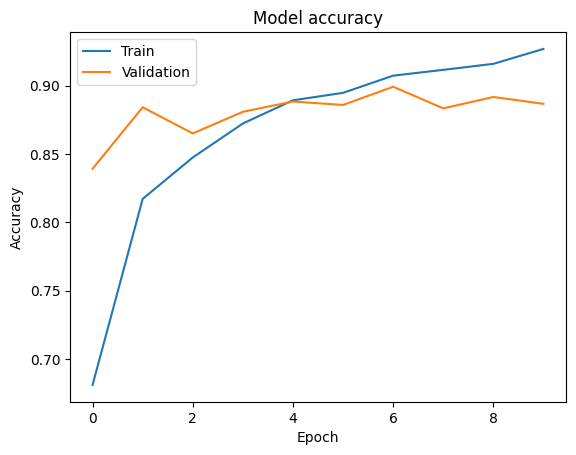

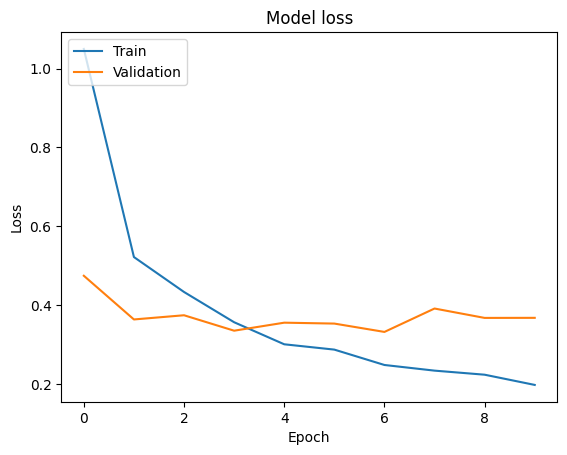

In [11]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Define the model architecture
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('bestn_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Train the model
history = model.fit(
    train_data, train_labels,
    epochs=10,
    batch_size=batch_size,
    validation_data=(validation_data, validation_labels),
    callbacks=[checkpoint, early_stopping]
)

# Load the best model
model = load_model('bestn_model.keras')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Plot the training and validation accuracy and loss
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
#Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,272,980 (73.52 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,848,654 (49.01 MB)

In [13]:
model.evaluate(test_data, test_labels)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8892 - loss: 0.3005


[0.3120213449001312, 0.8966666460037231]

In [14]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[5.28549999e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.35264814e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.24647057e-01 0.00000000e+00]
   [3.83541435e-02 0.00000000e+00 1.62516326e-01 ... 0.00000000e+00
    6.60005689e-01 0.00000000e+00]
   ...
   [3.31289619e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.20122695e-01 0.00000000e+00]
   [9.11579370e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.20876145e+00 0.00000000e+00]
   [8.35042238e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.23689663e+00 0.00000000e+00]]

  [[4.43065673e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.57150149e-01 0.00000000e+00]
   [5.73630333e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.99778354e-01 0.00000000e+00]
   [4.03459847e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.91696107e-01 0.00000000e+00]
   ...
   [2.06359774e-01 0.00000000e+00 0.00000000e+0

In [15]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

 butterflies       0.97      0.90      0.93       150
    chickens       0.90      0.83      0.87       150
   elephants       0.86      0.93      0.89       150
      horses       0.97      0.82      0.89       150
     spiders       0.89      0.96      0.93       150
   squirells       0.94      0.87      0.90       150

   micro avg       0.92      0.89      0.90       900
   macro avg       0.92      0.89      0.90       900
weighted avg       0.92      0.89      0.90       900
 samples avg       0.89      0.89      0.89       900



c:\Users\mdhan\OneDrive\Desktop\image classification\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [17]:
from sklearn.metrics import confusion_matrix

# Assuming categorical_test_labels and categorical_preds are defined properly
conf_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

# Now you can use conf_matrix for further analysis or printing
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[141   0   0   0   8   1]
 [  9 125   6   1   4   5]
 [  3   3 139   3   0   2]
 [  9   2  15 123   0   1]
 [  5   1   0   0 144   0]
 [  4   8   2   0   5 131]]


In [18]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[327   6   0   0  35   3]
 [  7 178   1   6   7   4]
 [  1   3 136   8   1   3]
 [  5   3  12 450   0   2]
 [  8   2   1   1 390   1]
 [  2   4   3   1   9 225]]
Normalized confusion matrix
[[0.88140162 0.01617251 0.         0.         0.09433962 0.00808625]
 [0.03448276 0.87684729 0.00492611 0.02955665 0.03448276 0.01970443]
 [0.00657895 0.01973684 0.89473684 0.05263158 0.00657895 0.01973684]
 [0.01059322 0.00635593 0.02542373 0.95338983 0.         0.00423729]
 [0.01985112 0.00496278 0.00248139 0.00248139 0.96774194 0.00248139]
 [0.00819672 0.01639344 0.01229508 0.00409836 0.03688525 0.92213115]]


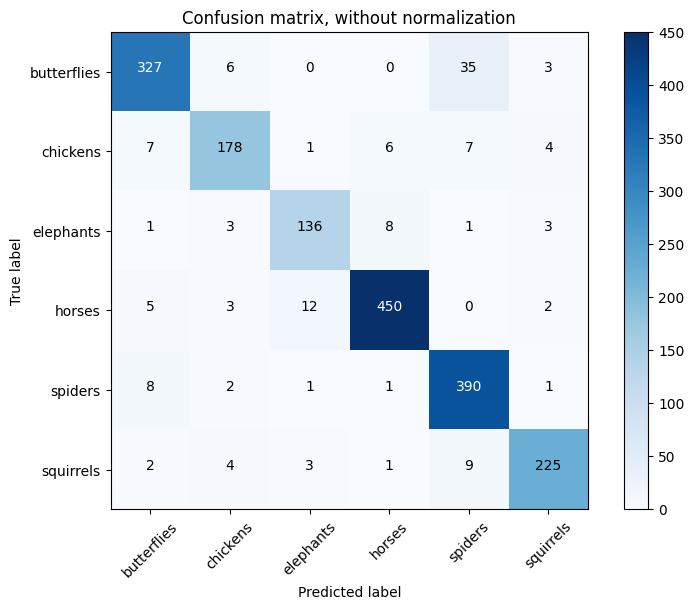

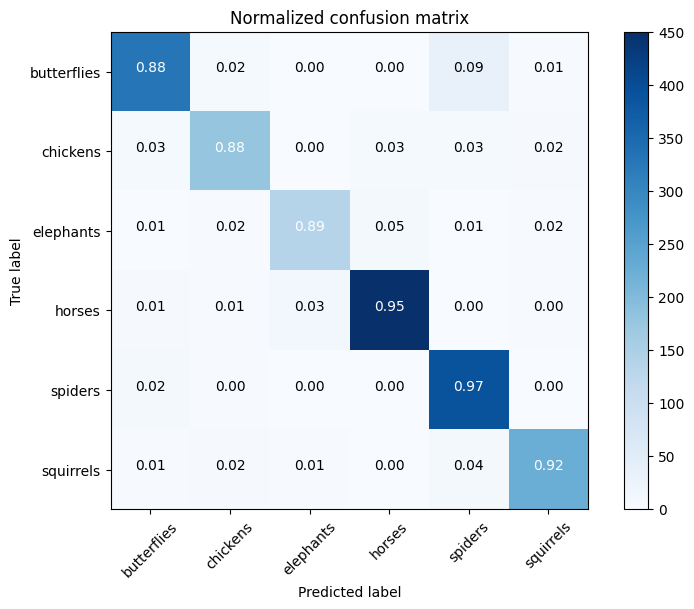

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Example confusion matrix data
conf_matrix = np.array([[327, 6, 0, 0, 35, 3],
                        [7, 178, 1, 6, 7, 4],
                        [1, 3, 136, 8, 1, 3],
                        [5, 3, 12, 450, 0, 2],
                        [8, 2, 1, 1, 390, 1],
                        [2, 4, 3, 1, 9, 225]])

# List of class names
classes = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirrels']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
